# AWS Configuration

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
#!pip install seaborn

In [3]:
import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib inline 

In [4]:
#!pip install s3fs

In [5]:
region = boto3.Session().region_name
print(region)

us-east-1


In [6]:
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::767397732163:role/service-role/AmazonSageMaker-ExecutionRole-20250128T080284


# S3 Buckets Setup

In [7]:
s3_client = boto3.client('s3')
bucket_name = 'mlops-assesment-deep'
# s3_client.create_bucket(Bucket=bucket_name)

### defining prefixes for organizing the data

In [8]:
model_dir = f's3://{bucket_name}/models/'
data_dir = f's3://{bucket_name}/data/'
captured_data_dir = f's3://{bucket_name}/captured-data/'

# Variables Setup

In [9]:
model_directory = f's3://{bucket_name}/models/'
data_directory = f's3://{bucket_name}/data/'
captured_data_dir = f's3://{bucket_name}/captured-data/'
model_file = 'model.tar.gz'
train_data = 'train.csv'
test_data = 'test.csv'
baseline_data = 'baseline.csv'  # If required
metadata = 'metadata.json'  # If required

# S3 Authentication

In [10]:
s3_client = boto3.client('s3')
response = s3_client.list_buckets()
print(response['Buckets'])

[{'Name': 'mlops-assesment-deep', 'CreationDate': datetime.datetime(2025, 1, 28, 4, 29, 17, tzinfo=tzlocal())}, {'Name': 'sagemaker-studio-767397732163-ho6x1donhb9', 'CreationDate': datetime.datetime(2025, 1, 28, 2, 32, 40, tzinfo=tzlocal())}, {'Name': 'sagemaker-us-east-1-767397732163', 'CreationDate': datetime.datetime(2025, 1, 28, 2, 32, 43, tzinfo=tzlocal())}]


# Data upload

In [11]:
# s3_client.upload_file('train.csv', bucket_name, 'data/train.csv')

In [12]:
# s3_client.upload_file('train_2.csv', bucket_name, 'data/train_2.csv')

In [13]:
# s3_client.upload_file('test_2.csv', bucket_name, 'data/test2.csv')

# Data Eyeballing

In [14]:
train = pd.read_csv("train_2.csv")
test = pd.read_csv("test_2.csv")

# Overview 

In [15]:
train.shape,test.shape

((150150, 9), (13860, 8))

* 1.5 lacs record its huge dataset a pickle would have been a better option

In [16]:
train.dtypes

record_ID            int64
week                object
store_id             int64
sku_id               int64
total_price        float64
base_price         float64
is_featured_sku      int64
is_display_sku       int64
units_sold           int64
dtype: object

# Inference
* record_id,total_price,base_price,units_sold data_types is good because the values match the datatypes 
* week's datatype is wrong because column value contains
* store_id,sku_id,is_featured_sku,is_display_sku requires further more investigation to conclude they converted to a category but as of now they look like they can be converted to category



# Action points
* Investigate store_id,sku_id,is_featured_sku,is_display_sku columns

In [17]:
def check_cat_conversion(threshold = 5):
    res = []
    for j,i in enumerate(train.columns):
        val = round((train[i].nunique()/train.shape[0])*100,2)
        
        if val<=threshold and (train[i].dtypes not in ('float64','object')):
            res.append((i,val))
            #df[i] = df[i].astype('category')
        else:
            continue
    return res


In [18]:
check_cat_conversion()

[('store_id', 0.05),
 ('sku_id', 0.02),
 ('is_featured_sku', 0.0),
 ('is_display_sku', 0.0),
 ('units_sold', 0.47)]

# Inference
* unit sold can be skipped 
# action points
* rest all can be converted to type category

In [19]:
train['week'] =pd.to_datetime(train['week'],format="%d/%m/%y")
train[['week']].head()

,week
0,2011-01-17
1,2011-01-17
2,2011-01-17
3,2011-01-17
4,2011-01-17


In [20]:
train['store_id'] = train['store_id'].astype('category')
train['sku_id'] = train['sku_id'].astype('category')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   record_ID        150150 non-null  int64         
 1   week             150150 non-null  datetime64[ns]
 2   store_id         150150 non-null  category      
 3   sku_id           150150 non-null  category      
 4   total_price      150149 non-null  float64       
 5   base_price       150150 non-null  float64       
 6   is_featured_sku  150150 non-null  int64         
 7   is_display_sku   150150 non-null  int64         
 8   units_sold       150150 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(2), int64(4)
memory usage: 8.3 MB


# EDA

In [21]:
train.describe()

,record_ID,week,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,2012-04-13 01:06:27.692307712,206.626751,219.425927,0.095611,0.133200,51.674206
min,1.000000,2011-01-17 00:00:00,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,2011-08-29 00:00:00,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,2012-04-13 12:00:00,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,2012-11-27 00:00:00,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,2013-07-09 00:00:00,562.162500,562.162500,1.000000,1.000000,2876.000000
std,61386.037861,NaN,103.308516,110.961712,0.294058,0.339792,60.207904


# observations
* recordID can be ignored beacuse its basically a no. that identitifies each row uniquely
* is_feartured_sku can be ignored beacuse its a category and for training it is necessary it remains a number
* is_display_sku can be ignored beacuse its a category and for training it is necessary it remains a number
## total_price
* mean > median a slight right skewness will be there in the data and the standard deviation is high so data is not well distributed and mean > standard deviation the normal curve will be a bit flattened and range of the data is 41 to 562
* outliers are present 
## base_price
* mean > median a slight right skewness will be there in the data and the standard deviation is high so data is not well distributed and mean > standard deviation the normal curve will be a bit flattened and range of the data is 61 to 562.
* comparing the ranges of the total_price and base price it is clear that there total_price < base_price which means some items are being sold below base price hence reason can be investigated for this loss in total_price
* outliers are present

## units_sold
* mean > median a right skewness will be there in the data and the standard deviation is high so data is not well distributed and mean < standard deviation the normal curve will be a sharp peak and range of the data is 1 to 2876
* outliers are present

In [22]:
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [23]:
def UVA_numeric(data,var_group):
    """
    Univariate Numerical Anlaysis and plot/print all descriptives and properties along with KDE
    input dataframe, variable group
    returns a loop: calculates all the descriptives of ith variable plots/prints it
    """
    size = len(var_group)
    plt.figure(figsize = (7*size,3),dpi = 140)
    
    #looping each variable group
    for j,i in enumerate(var_group):
        
        #calculating descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()
        
        #calculating points of standard_deviation 
        points = mean - st_dev,mean + st_dev
        
        #potting the variable with every piece of information
        plt.subplot(1,size,j+1)
        sns.kdeplot(data[i],fill = True)
        sns.lineplot(x=points, y=[0, 0], color='black', label='std_dev')
        sns.scatterplot(x=[mini, maxi], y=[0, 0], color='orange', label="min/max")
        sns.scatterplot(x=[mean], y=[0], color='red', label='mean')
        sns.scatterplot(x=[median], y=[0], color='blue', label='median')
        plt.xlabel('{}'.format(i),fontsize=20)
        plt.ylabel('Density')
        plt.title('std_dev = {}; kurtosis = {}; \nskew = {}; range = {}; \nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                         round(kurt,2),
                                                                                                         round(skew,2),
                                                                                                         (round(mini,2),round(maxi,2)),
                                                                                                         round(mean,2),
                                                                                                         round(median,2)))

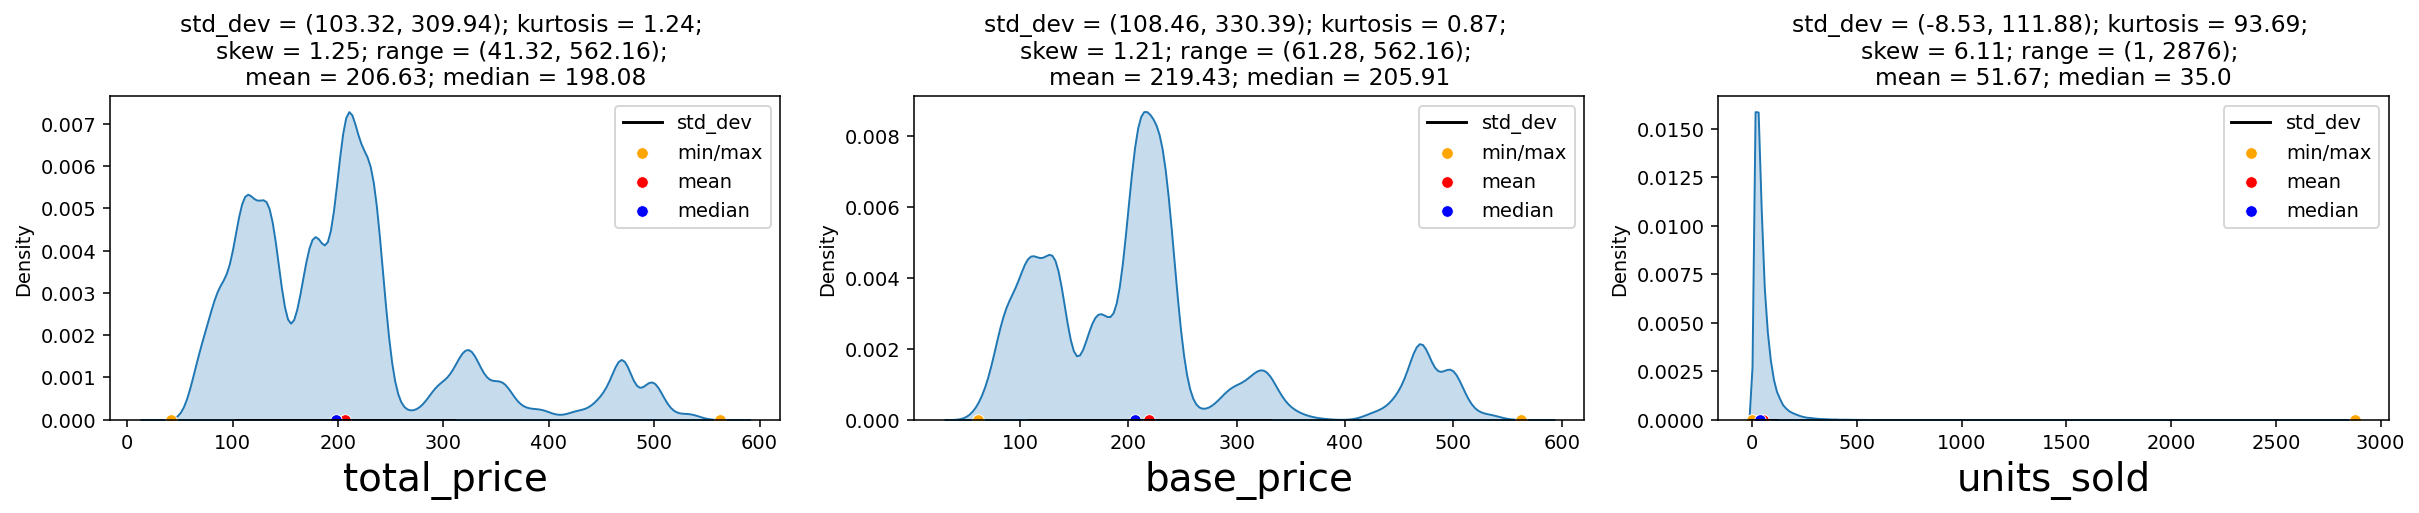

In [24]:
UVA_numeric(train,['total_price','base_price','units_sold'])

# observations
### total price
* clearly it has outliers but these outliers are important can be point of interest cane help further analysis
* skew >0.5: positively/right skewed
* kurtosis > 0: High extreme values are there and fatter tail we can visually verified 
### base price
* clearly it has outliers but these outliers are important can be point of interest cane help further analysis
* skew >0.5: positively/right skewed
* kurtosis > 0: High extreme values are there and fatter tail we can visually verified
### units sold
* clearly outliers are there but visually not able to verify
* skew >>> 0.5 -> positively/right skewed
* kurtosis >>> 0 High extreme values are there and fatter tail we can visually verified

In [25]:
def UVA_outlier(data, var_group, include_outlier = True):
    '''
    Univariate_Analysis_outlier:
    takes a group of variables (INTEGER and FLOAT) and plot/print boplot and descriptives\n
    Runs a loop: calculate all the descriptives of i(th) variable and plot/print it \n\n

    data : dataframe from which to plot from\n
    var_group : {list} type Group of Continuous variables\n
    include_outlier : {bool} whether to include outliers or not, default = True\n
    '''

    size = len(var_group)
    plt.figure(figsize = (7*size,4), dpi = 100)
  
    #looping for each variable
    for j,i in enumerate(var_group):

        # calculating descriptives of variable
        quant25 = data[i].quantile(0.25)
        quant75 = data[i].quantile(0.75)
        IQR = quant75 - quant25
        med = data[i].median()
        whis_low = quant25-(1.5*IQR)
        whis_high = quant75+(1.5*IQR)

        # Calculating Number of Outliers
        outlier_high = len(data[i][data[i]>whis_high])
        outlier_low = len(data[i][data[i]<whis_low])

        if include_outlier == True:
            print(include_outlier)
            #Plotting the variable with every information
            plt.subplot(1,size,j+1)
            sns.boxplot(data=data[i], orient="v")
            plt.ylabel('{}'.format(i))
            plt.title('With Outliers\nIQR = {}; Median = {} \n 1st,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                       round(IQR,2),
                                                                                                       round(med,2),
                                                                                                       (round(quant25,2),round(quant75,2)),
                                                                                                       (outlier_low,outlier_high)
                                                                                                       ))
      
        else:
            # replacing outliers with max/min whisker
            data2 = data[var_group][:]
            data2[i][data2[i]>whis_high] = whis_high+1
            data2[i][data2[i]<whis_low] = whis_low-1

            # plotting without outliers
            plt.subplot(1,size,j+1)
            sns.boxplot(data=data2[i], orient="v")
            plt.ylabel('{}'.format(i))
            plt.title('Without Outliers\nIQR = {}; Median = {} \n 1st,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                       round(IQR,2),
                                                                                                       round(med,2),
                                                                                                       (round(quant25,2),round(quant75,2)),
                                                                                                       (outlier_low,outlier_high)
                                                                                                       ))

True
True
True


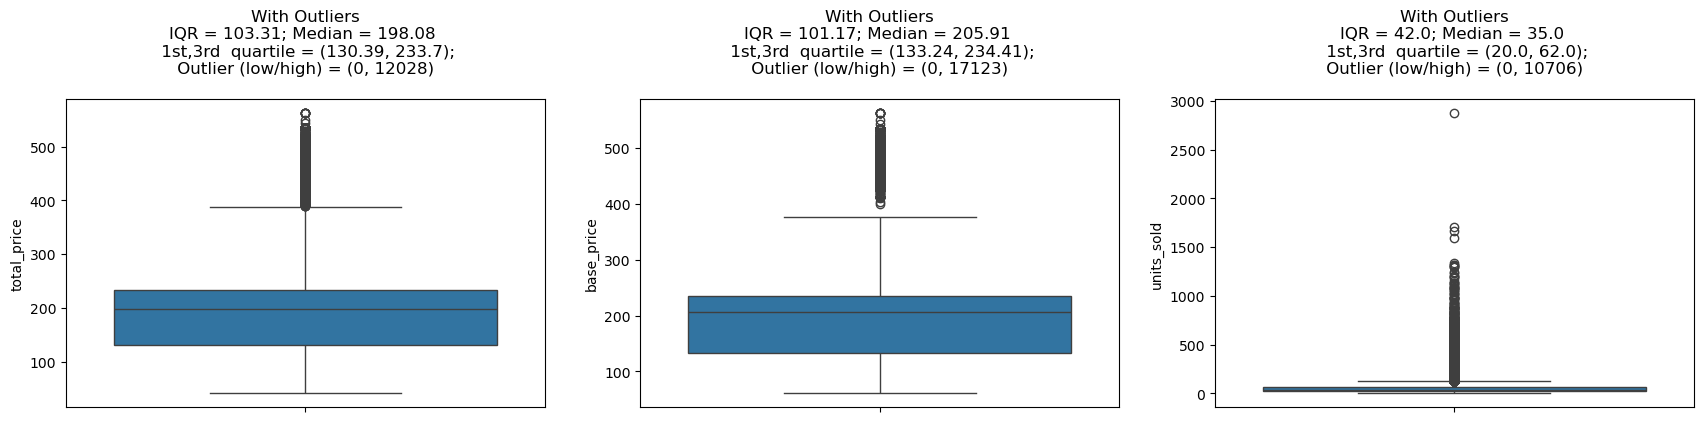

In [26]:
UVA_outlier(train,['total_price','base_price','units_sold'])

* we should remove the outlier from units sold because its my target variable

<Axes: xlabel='units_sold', ylabel='Count'>

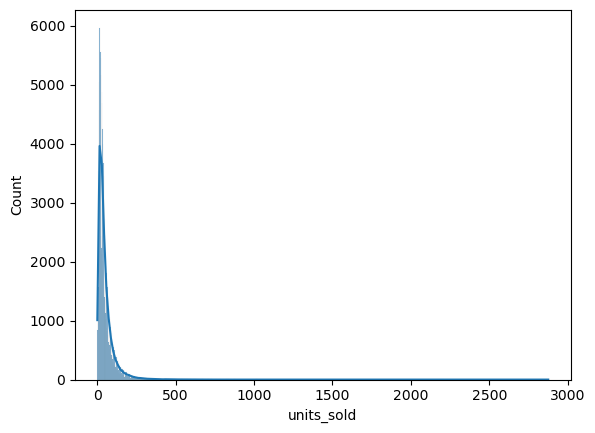

In [27]:
sns.histplot(train['units_sold'], kde=True)

In [28]:
print(train.shape)

(150150, 9)


In [29]:
Q1 = train['units_sold'].quantile(0.05)
Q3 = train['units_sold'].quantile(0.95)
IQR = Q3 - Q1
train = train[~((train['units_sold'] < (Q1 - 1.5 * IQR)) |(train['units_sold'] > (Q3 + 1.5 * 
IQR)))]

print(train.shape)

(149366, 9)


In [30]:
def UVA_category(data,var_group):
    """
    Univariate analysis categorical 
    takes a group of variables(category) and plot/print all the value counts and barplot
    """
    #setting figure size
    size = len(var_group)
    plt.figure(figsize = (7*size,5),dpi = 140)
    
    for j,i in enumerate(var_group):
        norm_count =  data[i].value_counts(normalize = True)
        n_uni = data[i].nunique()
        
        plt.subplot(1,size,j+1)
        sns.barplot(x=norm_count, y=norm_count.index, order=norm_count.index)
        plt.xlabel('fraction/percent',fontsize = 20)
        plt.ylabel('{}'.format(i),fontsize=20)
        plt.title('n_uniques = {} \n value counts \n{};'.format(n_uni,norm_count))

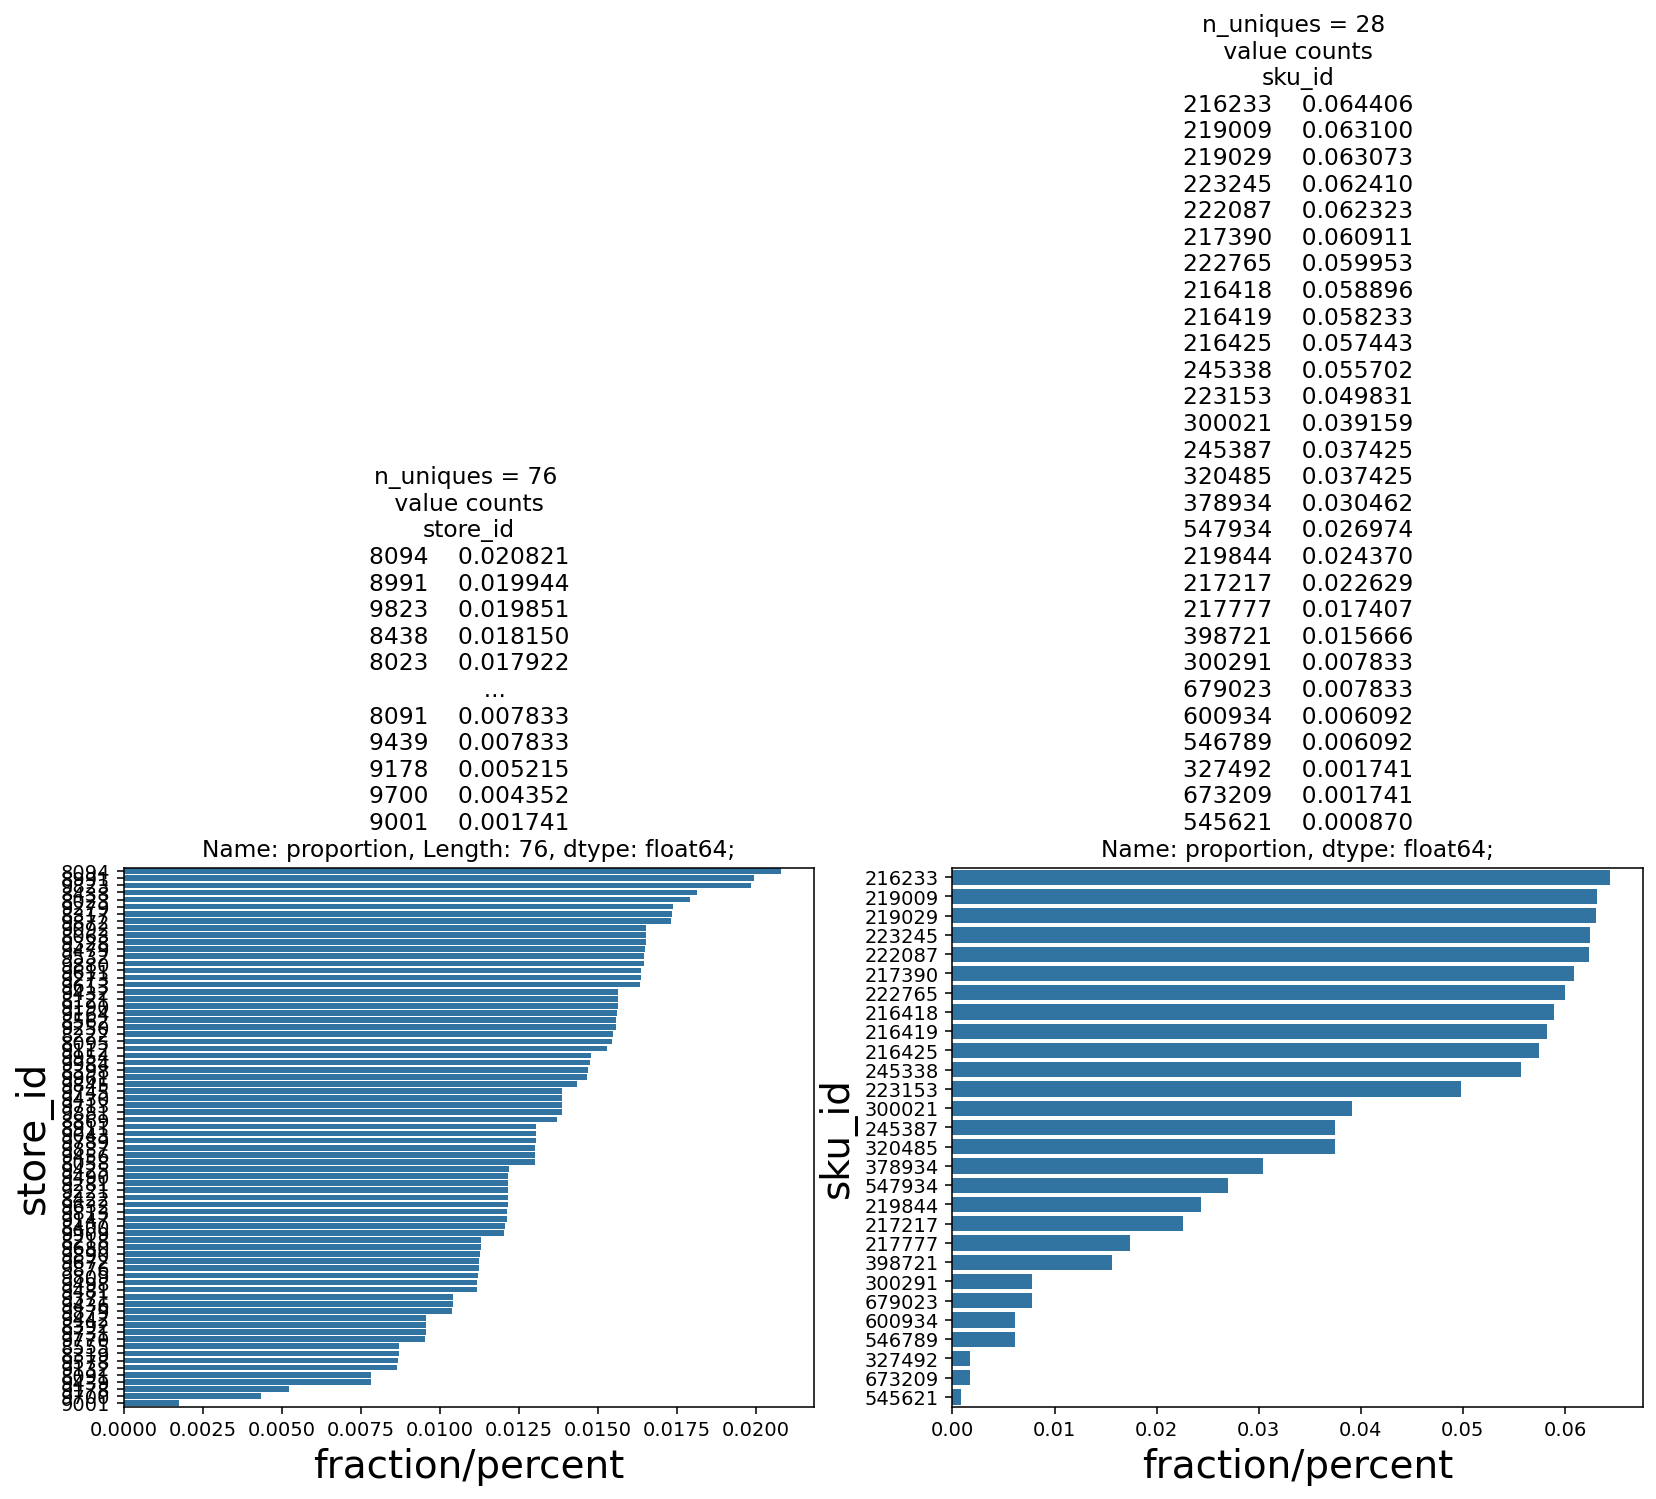

In [31]:
UVA_category(train,['store_id','sku_id'])

<Axes: >

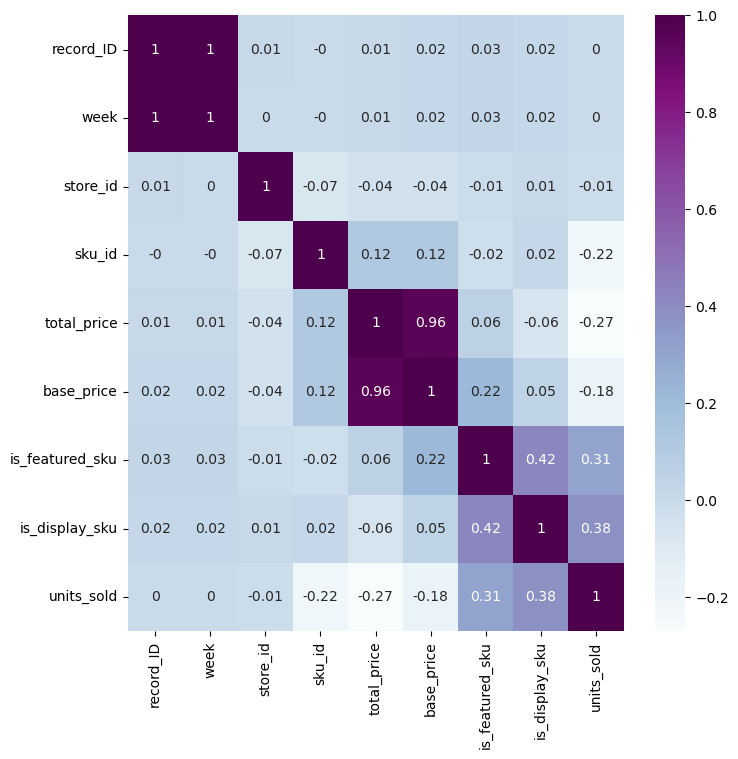

In [32]:
plt.figure(figsize=(8,8))
correlation =round(train.corr(method = 'pearson'),2)
sns.heatmap(correlation,cmap='BuPu',annot = True)

In [33]:
train.dtypes

record_ID                   int64
week               datetime64[ns]
store_id                 category
sku_id                   category
total_price               float64
base_price                float64
is_featured_sku             int64
is_display_sku              int64
units_sold                  int64
dtype: object

In [34]:
train.dropna(inplace = True)

In [35]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [36]:
X = train.iloc[:,4:-1]
calc_vif(X)

,variables,VIF
0,total_price,92.678607
1,base_price,98.346132
2,is_featured_sku,1.774597
3,is_display_sku,1.409043


* in the VIF test base price and total proce they failed the test one of them i.e base price can be dropped easily

In [37]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(X, axis=0)

array([0.22535307, 0.22204962, 1.22733246, 1.21384425])

* total price and base price has postive autocorrelation
* drop week column after extracting important features
* drop record id and base price


In [38]:
train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,2013-07-09,9984,223245,235.8375,235.8375,0,0,38
150146,212639,2013-07-09,9984,223153,235.8375,235.8375,0,0,30
150147,212642,2013-07-09,9984,245338,357.6750,483.7875,1,1,31
150148,212643,2013-07-09,9984,547934,141.7875,191.6625,0,1,12


# Feature Extraction

In [39]:
train['month'] = train['week'].apply(lambda x:x.month) 
#train['day'] = train['week'].apply(lambda x:x.day)
#train['year'] = train['week'].apply(lambda x:x.year)  
#train['week_of_year'] = train['week'].apply(lambda x:x.weekofyear)
train['day_of_week'] = train['week'].apply(lambda x:x.dayofweek)
train['Weekday'] = np.where(train['day_of_week']>4,1,0)

train

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold,month,day_of_week,Weekday
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20,1,0,0
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28,1,0,0
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19,1,0,0
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44,1,0,0
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
150145,212638,2013-07-09,9984,223245,235.8375,235.8375,0,0,38,7,1,0
150146,212639,2013-07-09,9984,223153,235.8375,235.8375,0,0,30,7,1,0
150147,212642,2013-07-09,9984,245338,357.6750,483.7875,1,1,31,7,1,0
150148,212643,2013-07-09,9984,547934,141.7875,191.6625,0,1,12,7,1,0


# Implementing the action points
* removed week,record and base price

In [40]:
train.drop(['record_ID','week','base_price'],axis = 1,inplace = True)
train

,store_id,sku_id,total_price,is_featured_sku,is_display_sku,units_sold,month,day_of_week,Weekday
0,8091,216418,99.0375,0,0,20,1,0,0
1,8091,216419,99.0375,0,0,28,1,0,0
2,8091,216425,133.9500,0,0,19,1,0,0
3,8091,216233,133.9500,0,0,44,1,0,0
4,8091,217390,141.0750,0,0,52,1,0,0
...,...,...,...,...,...,...,...,...,...
150145,9984,223245,235.8375,0,0,38,7,1,0
150146,9984,223153,235.8375,0,0,30,7,1,0
150147,9984,245338,357.6750,1,1,31,7,1,0
150148,9984,547934,141.7875,0,1,12,7,1,0


In [41]:
train = train.reindex(columns=['store_id', 'sku_id', 'total_price', 'is_featured_sku','is_display_sku','month',
                               'day_of_week','Weekday','units_sold'])
train

,store_id,sku_id,total_price,is_featured_sku,is_display_sku,month,day_of_week,Weekday,units_sold
0,8091,216418,99.0375,0,0,1,0,0,20
1,8091,216419,99.0375,0,0,1,0,0,28
2,8091,216425,133.9500,0,0,1,0,0,19
3,8091,216233,133.9500,0,0,1,0,0,44
4,8091,217390,141.0750,0,0,1,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,9984,223245,235.8375,0,0,7,1,0,38
150146,9984,223153,235.8375,0,0,7,1,0,30
150147,9984,245338,357.6750,1,1,7,1,0,31
150148,9984,547934,141.7875,0,1,7,1,0,12


 * base price and units sold are in high numbers they can create a bias so scale it down to lower numbers

# Scaling and Encoding
 * One-Hot Encoding turns each unique category (like store_id and sku_id) into a separate column with binary values (0 or 1).
* We dropped the first category of both columns (store_id and sku_id) to avoid multicollinearity. This means one category from each will not have a corresponding column, which is a standard approach to prevent redundancy.

In [42]:

from sklearn.preprocessing import OneHotEncoder

# Target variable
target = train['units_sold']

# One-Hot Encoding for store_id (76 unique values)
one_hot_encoder_store = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity
store_encoded = one_hot_encoder_store.fit_transform(train[['store_id']])
store_encoded_df = pd.DataFrame(store_encoded, columns=one_hot_encoder_store.get_feature_names_out(['store_id']))

# One-Hot Encoding for sku_id (28 unique values)
one_hot_encoder_sku = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity
sku_encoded = one_hot_encoder_sku.fit_transform(train[['sku_id']])
sku_encoded_df = pd.DataFrame(sku_encoded, columns=one_hot_encoder_sku.get_feature_names_out(['sku_id']))

# Combine encoded features with the original dataset
train_encoded = pd.concat([train.drop(['store_id', 'sku_id'], axis=1), store_encoded_df, sku_encoded_df], axis=1)

# Display the encoded dataset
print(train_encoded)


        total_price  is_featured_sku  is_display_sku  month  day_of_week  \
0           99.0375              0.0             0.0    1.0          0.0   
1           99.0375              0.0             0.0    1.0          0.0   
2          133.9500              0.0             0.0    1.0          0.0   
3          133.9500              0.0             0.0    1.0          0.0   
4          141.0750              0.0             0.0    1.0          0.0   
...             ...              ...             ...    ...          ...   
149013          NaN              NaN             NaN    NaN          NaN   
149074          NaN              NaN             NaN    NaN          NaN   
149110          NaN              NaN             NaN    NaN          NaN   
149199          NaN              NaN             NaN    NaN          NaN   
149294          NaN              NaN             NaN    NaN          NaN   

        Weekday  units_sold  store_id_8058  store_id_8063  store_id_8091  ...  \
0     

In [43]:
train_encoded

,total_price,is_featured_sku,is_display_sku,month,day_of_week,Weekday,units_sold,store_id_8058,store_id_8063,store_id_8091,...,sku_id_320485,sku_id_327492,sku_id_378934,sku_id_398721,sku_id_545621,sku_id_546789,sku_id_547934,sku_id_600934,sku_id_673209,sku_id_679023
0,99.0375,0.0,0.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,99.0375,0.0,0.0,1.0,0.0,0.0,28.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133.9500,0.0,0.0,1.0,0.0,0.0,19.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,133.9500,0.0,0.0,1.0,0.0,0.0,44.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,141.0750,0.0,0.0,1.0,0.0,0.0,52.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
train_encoded.fillna(0, inplace=True)
train_encoded

,total_price,is_featured_sku,is_display_sku,month,day_of_week,Weekday,units_sold,store_id_8058,store_id_8063,store_id_8091,...,sku_id_320485,sku_id_327492,sku_id_378934,sku_id_398721,sku_id_545621,sku_id_546789,sku_id_547934,sku_id_600934,sku_id_673209,sku_id_679023
0,99.0375,0.0,0.0,1.0,0.0,0.0,20.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,99.0375,0.0,0.0,1.0,0.0,0.0,28.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133.9500,0.0,0.0,1.0,0.0,0.0,19.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,133.9500,0.0,0.0,1.0,0.0,0.0,44.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,141.0750,0.0,0.0,1.0,0.0,0.0,52.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149013,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149074,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149110,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149199,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
train = train_encoded

In [46]:
train['total_price'] = train['total_price'].apply(lambda x:np.log(x))
train['units_sold'] = train['units_sold'].apply(lambda x:np.log(x))
train

/tmp/ipykernel_8146/1283854935.py:1: RuntimeWarning: divide by zero encountered in log
  train['total_price'] = train['total_price'].apply(lambda x:np.log(x))
/tmp/ipykernel_8146/1283854935.py:2: RuntimeWarning: divide by zero encountered in log
  train['units_sold'] = train['units_sold'].apply(lambda x:np.log(x))


,total_price,is_featured_sku,is_display_sku,month,day_of_week,Weekday,units_sold,store_id_8058,store_id_8063,store_id_8091,...,sku_id_320485,sku_id_327492,sku_id_378934,sku_id_398721,sku_id_545621,sku_id_546789,sku_id_547934,sku_id_600934,sku_id_673209,sku_id_679023
0,4.595499,0.0,0.0,1.0,0.0,0.0,2.995732,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.595499,0.0,0.0,1.0,0.0,0.0,3.332205,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.897467,0.0,0.0,1.0,0.0,0.0,2.944439,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.897467,0.0,0.0,1.0,0.0,0.0,3.784190,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.949292,0.0,0.0,1.0,0.0,0.0,3.951244,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149013,-inf,0.0,0.0,0.0,0.0,0.0,-inf,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149074,-inf,0.0,0.0,0.0,0.0,0.0,-inf,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149110,-inf,0.0,0.0,0.0,0.0,0.0,-inf,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149199,-inf,0.0,0.0,0.0,0.0,0.0,-inf,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* checking if all are numbers or not

In [47]:
train.replace(-np.inf, 0, inplace=True)

In [48]:
train

,total_price,is_featured_sku,is_display_sku,month,day_of_week,Weekday,units_sold,store_id_8058,store_id_8063,store_id_8091,...,sku_id_320485,sku_id_327492,sku_id_378934,sku_id_398721,sku_id_545621,sku_id_546789,sku_id_547934,sku_id_600934,sku_id_673209,sku_id_679023
0,4.595499,0.0,0.0,1.0,0.0,0.0,2.995732,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.595499,0.0,0.0,1.0,0.0,0.0,3.332205,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.897467,0.0,0.0,1.0,0.0,0.0,2.944439,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.897467,0.0,0.0,1.0,0.0,0.0,3.784190,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.949292,0.0,0.0,1.0,0.0,0.0,3.951244,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149013,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149074,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149110,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149199,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
train.dtypes

total_price        float64
is_featured_sku    float64
is_display_sku     float64
month              float64
day_of_week        float64
                    ...   
sku_id_546789      float64
sku_id_547934      float64
sku_id_600934      float64
sku_id_673209      float64
sku_id_679023      float64
Length: 109, dtype: object

# uplaoding the latest file in S3

In [50]:
# csv_buffer = StringIO()
# train.to_csv(csv_buffer, index=False)

In [51]:
# s3_client.put_object(Bucket=bucket_name, Key='data/train_final.csv', Body=csv_buffer.getvalue())

In [52]:
print(train.columns.tolist())

['total_price', 'is_featured_sku', 'is_display_sku', 'month', 'day_of_week', 'Weekday', 'units_sold', 'store_id_8058', 'store_id_8063', 'store_id_8091', 'store_id_8094', 'store_id_8095', 'store_id_8121', 'store_id_8218', 'store_id_8222', 'store_id_8317', 'store_id_8319', 'store_id_8392', 'store_id_8398', 'store_id_8400', 'store_id_8422', 'store_id_8438', 'store_id_8555', 'store_id_8562', 'store_id_8869', 'store_id_8911', 'store_id_8991', 'store_id_9001', 'store_id_9043', 'store_id_9092', 'store_id_9112', 'store_id_9132', 'store_id_9147', 'store_id_9164', 'store_id_9178', 'store_id_9190', 'store_id_9221', 'store_id_9250', 'store_id_9273', 'store_id_9279', 'store_id_9281', 'store_id_9328', 'store_id_9371', 'store_id_9425', 'store_id_9430', 'store_id_9432', 'store_id_9436', 'store_id_9439', 'store_id_9442', 'store_id_9456', 'store_id_9479', 'store_id_9481', 'store_id_9490', 'store_id_9498', 'store_id_9532', 'store_id_9578', 'store_id_9611', 'store_id_9613', 'store_id_9632', 'store_id_9672

# Feature Sdelection

In [54]:
# Load training data from S3
train_data = pd.read_csv(f's3://{bucket_name}/data/train_final.csv')

# Perform feature selection
features = [ 'total_price', 'is_featured_sku', 'is_display_sku', 'month', 'day_of_week', 'Weekday', 'store_id_8058', 'store_id_8063', 'store_id_8091', 'store_id_8094', 'store_id_8095', 'store_id_8121', 'store_id_8218', 'store_id_8222', 'store_id_8317', 'store_id_8319', 'store_id_8392', 'store_id_8398', 'store_id_8400', 'store_id_8422', 'store_id_8438', 'store_id_8555', 'store_id_8562', 'store_id_8869', 'store_id_8911', 'store_id_8991', 'store_id_9001', 'store_id_9043', 'store_id_9092', 'store_id_9112', 'store_id_9132', 'store_id_9147', 'store_id_9164', 'store_id_9178', 'store_id_9190', 'store_id_9221', 'store_id_9250', 'store_id_9273', 'store_id_9279', 'store_id_9281', 'store_id_9328', 'store_id_9371', 'store_id_9425', 'store_id_9430', 'store_id_9432', 'store_id_9436', 'store_id_9439', 'store_id_9442', 'store_id_9456', 'store_id_9479', 'store_id_9481', 'store_id_9490', 'store_id_9498', 'store_id_9532', 'store_id_9578', 'store_id_9611', 'store_id_9613', 'store_id_9632', 'store_id_9672', 'store_id_9680', 'store_id_9700', 'store_id_9713', 'store_id_9731', 'store_id_9745', 'store_id_9770', 'store_id_9789', 'store_id_9809', 'store_id_9813', 'store_id_9823', 'store_id_9837', 'store_id_9845', 'store_id_9872', 'store_id_9876', 'store_id_9879', 'store_id_9880', 'store_id_9881', 'store_id_9890', 'store_id_9909', 'store_id_9954', 'store_id_9961', 'store_id_9984', 'sku_id_216418', 'sku_id_216419', 'sku_id_216425', 'sku_id_217217', 'sku_id_217390', 'sku_id_217777', 'sku_id_219009', 'sku_id_219029', 'sku_id_219844', 'sku_id_222087', 'sku_id_222765', 'sku_id_223153', 'sku_id_223245', 'sku_id_245338', 'sku_id_245387', 'sku_id_300021', 'sku_id_300291', 'sku_id_320485', 'sku_id_327492', 'sku_id_378934', 'sku_id_398721', 'sku_id_545621', 'sku_id_546789', 'sku_id_547934', 'sku_id_600934', 'sku_id_673209', 'sku_id_679023']
target = ['units_sold']
X_train = train_data[features]
y_train = train_data[target]

# Save preprocessed data back to S3
# X_train.to_csv(f's3://{bucket_name}/data/preprocessed_train.csv', index=False)

In [60]:
# Separate the data into input X and Output y
X_train.shape

(150142, 108)

In [59]:
y_train.shape

(150142, 1)

In [61]:
# Convert the datatype to float32
X = np.array(X_train).astype('float32')
y = np.array(y_train).astype('float32')

In [64]:
X.shape

(150142, 108)

In [65]:
y.shape

(150142, 1)

In [66]:
# split the data into training and testing using SkLearn Library
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Training the model

In [67]:
# Boto3 is the Amazon Web Services (AWS) Software Development Kit (SDK) for Python
# Boto3 allows Python developers to write software that makes use of services like Amazon S3 and Amazon EC2

import sagemaker
import boto3

# Initialize S3 client
s3_client = boto3.client('s3')

# Define S3 bucket and directories
bucket_name = 'mlops-assesment-deep'  # Your S3 bucket name
model_dir = model_directory  # Directory for model artifacts
data_dir = data_directory  # Directory for training/test data
captured_data_dir = captured_data_dir  # Directory for captured data

# Define file names
model_file = 'model.tar.gz'  # Pre-trained model file
train_data = 'train.csv'  # Training data file
test_data = 'test.csv'  # Test data file
baseline_data = 'baseline.csv'  # Baseline data file (if required)
metadata = 'metadata.json'  # Metadata file (if required)

# Create a SageMaker session
sagemaker_session = sagemaker.Session()

# Define the prefix (subfolder within the bucket)
prefix = 'linear_learner'  

# Get the execution role for the notebook instance
# This is the IAM role that SageMaker can assume to perform tasks on your behalf
role = sagemaker.get_execution_role()
print(f"IAM Role: {role}")

# Print the S3 paths for reference
print(f"Model Directory: {model_dir}")
print(f"Data Directory: {data_dir}")
print(f"Captured Data Directory: {captured_data_dir}")
print(f"Model File: {model_file}")
print(f"Train Data: {train_data}")
print(f"Test Data: {test_data}")
print(f"Baseline Data: {baseline_data}")
print(f"Metadata: {metadata}")

IAM Role: arn:aws:iam::767397732163:role/service-role/AmazonSageMaker-ExecutionRole-20250128T080284
Model Directory: s3://mlops-assesment-deep/models/
Data Directory: s3://mlops-assesment-deep/data/
Captured Data Directory: s3://mlops-assesment-deep/captured-data/
Model File: model.tar.gz
Train Data: train.csv
Test Data: test.csv
Baseline Data: baseline.csv
Metadata: metadata.json


In [68]:
X_train.shape


(120113, 108)

In [69]:
y_train = y_train[:,0]



In [70]:
y_train.shape

(120113,)

In [71]:
import io  # The io module allows for dealing with various types of I/O (text I/O, binary I/O, and raw I/O).
import numpy as np
import sagemaker.amazon.common as smac  # SageMaker common library for data serialization

# Convert the data in NumPy array format to RecordIO format
# RecordIO is a binary data format required by SageMaker's Linear Learner algorithm.

# Create an in-memory byte array (buffer) to store the serialized data
buf = io.BytesIO()

# Serialize the training data (X_train) and labels (y_train) into RecordIO format
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)

# Reset the buffer's position to the beginning
# This is necessary because writing to the buffer advances its position, and we need to read from the start later.
buf.seek(0)

# Optional: Verify the buffer's content size
print(f"Size of serialized data in buffer: {len(buf.getvalue())} bytes")

Size of serialized data in buffer: 57654240 bytes


In [72]:
import os

# Upload RecordIO data to S3

# Define the S3 key (path) for the training data
key = 'linear-train-data'  # Name of the file in S3

# Construct the full S3 path for the training data
s3_train_path = os.path.join(prefix, 'train', key)

# Upload the serialized data (from the buffer) to the specified S3 path
boto3.resource('s3').Bucket(bucket_name).Object(s3_train_path).upload_fileobj(buf)

# Print the S3 location of the uploaded training data
s3_train_data = f's3://{bucket_name}/{s3_train_path}'
print(f"Uploaded training data location: {s3_train_data}")

Uploaded training data location: s3://mlops-assesment-deep/linear_learner/train/linear-train-data


In [73]:
X_test.shape


(30029, 108)

In [74]:
y_test.shape


(30029, 1)

In [75]:
# Make sure that the target label is a vector
y_test = y_test[:,0]

In [76]:
# Convert the test data (X_test and y_test) into RecordIO format
# RecordIO is a binary data format required by SageMaker's Linear Learner algorithm.

# Create an in-memory byte array (buffer) to store the serialized data
buf = io.BytesIO()

# Serialize the test data (X_test) and labels (y_test) into RecordIO format
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)

# Reset the buffer's position to the beginning
# This is necessary because writing to the buffer advances its position, and we need to read from the start later.
buf.seek(0)

# Optional: Verify the buffer's content size
print(f"Size of serialized test data in buffer: {len(buf.getvalue())} bytes")

Size of serialized test data in buffer: 14413920 bytes


In [77]:
# Define the S3 key (path) for the test data
key = 'linear-test-data'  # Name of the file in S3

# Construct the full S3 path for the test data
s3_test_path = os.path.join(prefix, 'test', key)

# Upload the serialized test data (from the buffer) to the specified S3 path
boto3.resource('s3').Bucket(bucket_name).Object(s3_test_path).upload_fileobj(buf)

# Print the S3 location of the uploaded test data
s3_test_data = f's3://{bucket_name}/{s3_test_path}'
print(f"Uploaded test data location: {s3_test_data}")

Uploaded test data location: s3://mlops-assesment-deep/linear_learner/test/linear-test-data


In [78]:
# create an output placeholder in S3 bucket to store the linear learner output

output_location = 's3://{}/{}/output'.format(bucket_name, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

Training artifacts will be uploaded to: s3://mlops-assesment-deep/linear_learner/output


In [79]:
# Retrieve the container image URI for the SageMaker Linear Learner algorithm
# The `sagemaker.image_uris.retrieve` method automatically fetches the correct image URI based on the algorithm name and region.

container = sagemaker.image_uris.retrieve(
    framework="linear-learner",  # Name of the built-in algorithm
    region=boto3.Session().region_name  # Automatically detect the current AWS region
)

# Print the container image URI for reference
print(f"Linear Learner container image URI: {container}")

Linear Learner container image URI: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


# Training the Model

In [80]:
# Define the SageMaker Estimator for Linear Learner
linear = sagemaker.estimator.Estimator(
    image_uri=container,  # Container image URI for Linear Learner
    role=role,  # IAM role for SageMaker
    instance_count=1,  # Number of training instances
    instance_type='ml.m5.xlarge',  # Instance type for training (ml.m5.xlarge is more cost-effective than ml.m4.xlarge)
    output_path=output_location,  # S3 path for saving model artifacts
    sagemaker_session=sagemaker_session  # SageMaker session
)

# Set hyperparameters for the Linear Learner algorithm
# Adjust hyperparameters based on the dataset dimensions (120113 rows, 108 features)
linear.set_hyperparameters(
    feature_dim=108,  # Number of features (columns) in the dataset
    predictor_type='regressor',  # Type of predictor (regressor or classifier)
    mini_batch_size=100,  # Mini-batch size (adjust based on dataset size)
    epochs=10,  # Number of epochs (increase for better convergence)
    num_models=32,  # Number of models to train in parallel (for hyperparameter optimization)
    loss='absolute_loss'  # Loss function (absolute_loss for regression)
)

# Start the training job using the training data from S3
linear.fit({'train': s3_train_data})

# Monitor the training progress using Amazon CloudWatch logs

INFO:sagemaker:Creating training-job with name: linear-learner-2025-01-31-12-00-54-276


2025-01-31 12:00:57 Starting - Starting the training job...
2025-01-31 12:01:11 Starting - Preparing the instances for training...
2025-01-31 12:01:34 Downloading - Downloading input data...
2025-01-31 12:02:00 Downloading - Downloading the training image......
2025-01-31 12:03:19 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/31/2025 12:03:27 INFO 140499873867584] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': '

# Creating a Sagemaker Entity

In [81]:
from sagemaker.model import Model

# Print the container image URI for reference
print(f"Linear Learner container image URI: {container}")

# Define the S3 path to the model artifacts generated by the training job
# The model artifacts are stored in the `output_location` specified during training
model_artifact = f"{output_location}/linear-learner-*/output/model.tar.gz"

# Create the SageMaker model entity
sagemaker_model = Model(
    model_data=model_artifact,  # S3 path to the trained model artifacts
    image_uri=container,  # Container image URI for the Linear Learner algorithm
    role=role,  # IAM role for SageMaker
    sagemaker_session=sagemaker_session  # SageMaker session
)

print("SageMaker model entity created.")

Linear Learner container image URI: 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1
SageMaker model entity created.


# Deploying the ENdpoint with Data Capture Enabled

In [85]:
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.session import Session
# Configure data capture
data_capture_config = DataCaptureConfig(
    enable_capture=True,  # Enable data capture
    sampling_percentage=100,  # Capture 100% of the data
    destination_s3_uri=captured_data_dir,  # S3 path for captured data
    capture_options=["INPUT", "OUTPUT"]  # Capture both input and output
)

# Create a SageMaker session
sagemaker_session = Session()

# Create an endpoint configuration
endpoint_config_name = 'linear-learner-endpoint-config'
sagemaker_session.create_endpoint_config(
    name=endpoint_config_name,
    model_name=sagemaker_model.name,  # Name of the SageMaker model entity
    initial_instance_count=1,
    instance_type='ml.m5.large',
    data_capture_config_dict=data_capture_config._to_request_dict()
)

print(f"Endpoint configuration '{endpoint_config_name}' created with data capture enabled.")

INFO:sagemaker:Creating endpoint-config with name linear-learner-endpoint-config


ClientError: An error occurred (ValidationException) when calling the CreateEndpointConfig operation: 2 validation errors detected: Value 'INPUT' at 'dataCaptureConfig.captureOptions.1.member.captureMode' failed to satisfy constraint: Member must satisfy enum value set: [Output, Input, InputAndOutput]; Value 'OUTPUT' at 'dataCaptureConfig.captureOptions.2.member.captureMode' failed to satisfy constraint: Member must satisfy enum value set: [Output, Input, InputAndOutput]